# CS211: Data Privacy
## In-Class Exercise, 9/19/2022

In [2]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')

# How much noise?! -> depends on the senesitivity of the data and the epsilon value
# Sensitivity measures teh influence of one person on the queries output
# max: x and x_prime to distinguish between neighboring datasets?
# how does f(x) change if one persons data is changed defines the sensitivity of a data point

## Question 1

Implement the Laplace mechanism below.

In [3]:
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity/epsilon)

In [4]:
# TEST CASE for question 1
dist1 = [laplace_mech(50, 1, 1.0) for _ in range(200)]
dist2 = [np.random.laplace(loc=50, scale=1) for _ in range(200)]

assert stats.wasserstein_distance(dist1, dist2) < 1

## Question 2

Write a query to count the number of people over age 30 (a property of data), with differntial privacy(ep=1)

In [5]:
def people_over_30_dp():
    true_answer = len(adult[adult['Age'] > 30])
    epsilon = 1
    return laplace_mech(true_answer, 1, epsilon) # Anything involved with counting a property should have a sensitivity of 1 

people_over_30_dp()

21988.302931781298

In [6]:
# TEST CASE for question 2
dist1 = [np.random.laplace(loc=21989, scale=1.0) for _ in range(200)]
dist2 = [people_over_30_dp() for _ in range(200)]

assert stats.wasserstein_distance(dist1, dist2) < 1

## Question 3

Consider the following definition of a differencing attack (without differential privacy).

In [7]:
def differencing_attack():
    q1 = adult['Age'].sum()
    q2 = adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()

    return q1 - q2

print('Differencing attack result:', differencing_attack())

Differencing attack result: 39


Implement a function `dp_differencing_attack` that performs the same attack, but attempts to satisfy differential privacy using the Laplace mechanism. Use the parameters `sensitivity=1` and `epsilon=1.0`.

In [8]:
def dp_differencing_attack():
    q1 = adult['Age'].sum()
    q2 = adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()
    
    # DP fails to protect against this attack because we go tthe sensitivity wrong.
    # If we removed Karries data from the data then q1 changes by 39 and q2 won't change at all
    # sensitivity of q1 should be at least 39, consider all the possible ranges of age... people don't usually live past 100
    epsilon = 1
    dp_q1 = laplace_mech(q1, 1, epsilon)
    dp_q2 = laplace_mech(q2, 1, epsilon)
    return dp_q1 - dp_q2

print('DP Differencing attack result:', dp_differencing_attack())

DP Differencing attack result: 37.333260944113135


In [9]:
# TEST CASE for question 1
dp_results = [dp_differencing_attack() for _ in range(100)]
spec = [np.random.laplace(loc=39, scale=1) for _ in range(100)]
assert stats.wasserstein_distance(dp_results, spec) < 2

## Question 4

What is the *sensitivity* of the `differencing_attack` query defined above, and why?

- The sensitivity of q1 and q2 is much greater than 1
- The actual sensitivity is equal to the maximum age a person could be

## Question 5

Implement a corrected version of `dp_differencing_attack` that uses the correct sensitivity and thus correctly satisfies differential privacy.

In [16]:
def dp_differencing_attack_corrected():
    q1 = adult['Age'].sum()
    q2 = adult[adult['Name'] != 'Karrie Trusslove']['Age'].sum()
    
    epsilon = 1
    sensitivity = 125 # the max age a person could have
    dp_q1 = laplace_mech(q1, sensitivity, epsilon)
    dp_q2 = laplace_mech(q2, sensitivity, epsilon)
    return dp_q1 - dp_q2

print('DP Differencing attack result:', dp_differencing_attack_corrected())

DP Differencing attack result: -189.5111559627112


In [11]:
# TEST CASE for question 3
dp_results = [dp_differencing_attack_corrected() for _ in range(100)]
spec = [np.random.laplace(loc=39, scale=125/2.0) for _ in range(100)]
assert stats.wasserstein_distance(dp_results, spec) < 200
assert stats.wasserstein_distance(dp_results, spec) > 50

## Question 6

Write a function `dp_mean_age` that calculates the mean age of members of the dataset.

In [12]:
def mean_age():
    return adult['Age'].mean()

mean_age()

38.58164675532078

In [17]:
def dp_mean_age(epsilon):
    # Calc dp private sum
    real_sum = adult['Age'].sum()
    noisy_sum = laplace_mech(real_sum, 125, epsilon / 2)
    
    # Calc a dp private count
    real_count = len(adult)
    noisy_count = laplace_mech(real_count, 1, epsilon / 2)
    
    #Return the quotient
    return noisy_sum / noisy_count

    # Satisfies (ep  / 2) + (ep / 2) dp = ep dp by sequential composition and post processing

In [18]:
# TEST CASE for question 1
results = [dp_mean_age(1) for _ in range(100)]
assert np.abs(np.mean(results) - mean_age()) < 0.1

## Question 7

Write a function `dp_age_sum_clipping` that uses clipping to bound the sensitivity of the sum of ages.

In [22]:
def dp_age_sum_clipping(epsilon, b):
    clipped_sum = adult['Age'].clip(lower=0, upper=b).sum()
    noisy_sum = laplace_mech(clipped_sum, b, epsilon)
    
    return noisy_sum
    
# Satisfies ep dp because the sensitivity of the summation is b and the laplace mechanism satisfies ep dp
    
dp_age_sum_clipping(1.0, 100)

1256184.7816514275

In [23]:
# TEST CASE for question 2
results = [dp_age_sum_clipping(1.0, 100) for _ in range(10)]
assert np.abs(np.mean(results) - adult['Age'].sum()) < 100

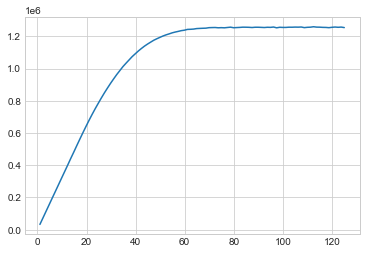

In [24]:
bs = np.linspace(1, 125, 100)
results = [dp_age_sum_clipping(0.1, b) for b in bs]
plt.plot(bs, results);

#baseline = [adult['Age'].sum() for b in bs]
#plt.plot(bs, baseline);